2019-05-03 18:54:04.284055 0.25 1240944862.2840552


/work/yifan.wang/virtualenv/3ogc/lib/python3.7/site-packages/ipykernel_launcher.py:103: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.


2019-07-01 20:33:06.567220 0.25 1246048404.5672204
2019-08-14 21:10:38.990208 3.415327027253798 1249852256.9902084
2017-04-03 23:06:11.244550 0.25 1175295989.24455
2015-09-14 09:50:45.409193 0.25 1126259462.409193
2019-07-27 06:03:33.963912 0.25 1248242631.9639122
2019-09-15 23:57:02.703295 0.25 1252627040.7032955
2019-09-24 02:18:46.827735 3.3065133475580804 1253326744.8277352
2019-04-25 08:18:05.033862 5 1240215503.0338616
2019-06-30 18:52:05.159765 0.25 1245955943.1597645
2015-10-12 09:54:43.421306 0.5276248923333389 1128678900.4213064
2019-06-02 17:59:27.090536 0.25 1243533585.0905356
2017-01-21 21:25:36.560970 0.25 1169069154.5609703
2019-05-19 15:35:44.359849 0.25 1242315362.3598492
2019-04-24 18:06:48.157536 0.25 1240164426.1575358
2017-08-09 08:28:21.751967 0.25 1186302519.7519667
2017-08-17 12:41:04.430206 5 1187008882.4302056
2017-06-08 02:01:16.498239 2.0226962802024864 1180922494.498239
2019-09-25 23:28:45.113944 0.4909551965500717 1253489343.113944
2019-06-20 03:04:21.3227

/work/yifan.wang/virtualenv/3ogc/lib/python3.7/site-packages/ipykernel_launcher.py:101: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


2019-04-13 13:43:08.705961 0.25 1239198206.7059608
2019-07-31 14:09:36.627350 0.25 1248617394.6273496
2019-09-29 01:21:49.474963 0.25 1253755327.4749627
2019-07-25 17:47:28.447234 1.880770715017269 1248112066.4472337
2017-01-04 10:11:58.614724 0.25 1167559936.6147244
2019-04-21 21:38:56.234560 0.25 1239917954.2345603
2019-07-07 09:33:26.176676 1.5965489390052814 1246527224.1766763
2017-08-18 02:25:09.084576 0.25 1187058327.0845761
2019-09-30 13:35:41.237525 1.5479384078853604 1253885759.2375252
2015-12-26 03:38:53.668132 1.6011128159113137 1135136350.6681318
2019-05-21 03:02:29.464669 0.25 1242442967.464669
2019-07-19 21:55:14.904560 0.25 1247608532.90456
2017-07-27 01:04:30.038907 0.25 1185152688.038907
2019-07-28 06:45:10.548105 1.4905388426433714 1248331528.548105
2017-02-02 13:56:57.746957 0.3518613543253389 1170079035.7469573
2019-05-13 20:54:28.723588 0.25 1241816086.7235885
2019-08-28 06:55:09.864032 0.5420907513473883 1251010527.8640316
2019-07-06 22:26:41.297991 0.25 124648721

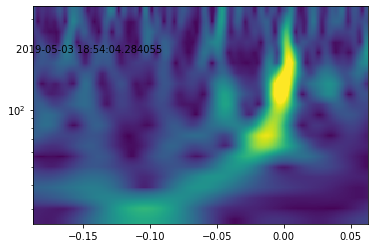

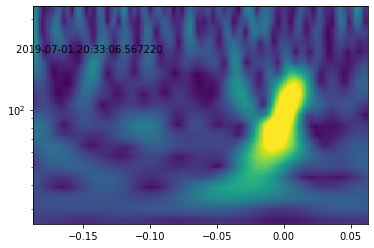

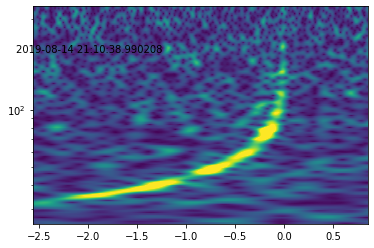

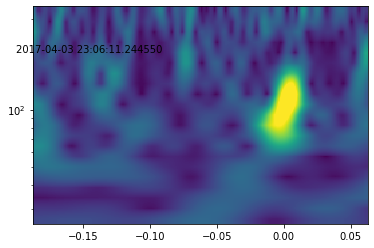

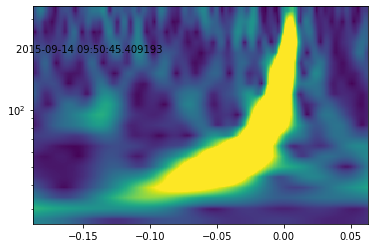

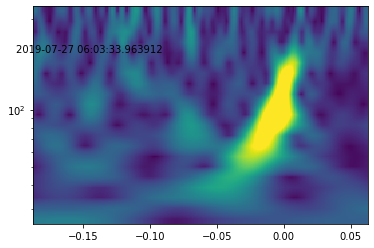

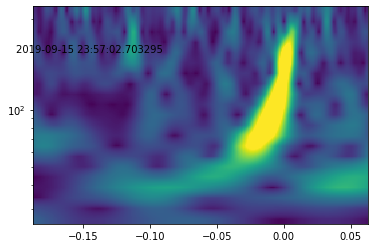

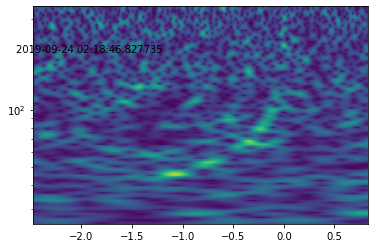

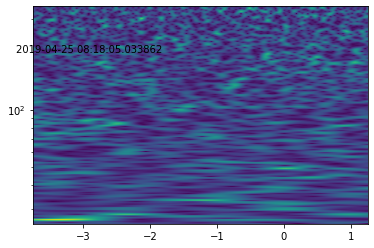

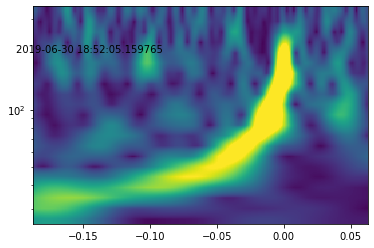

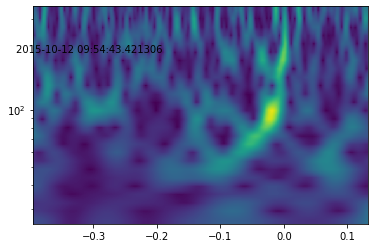

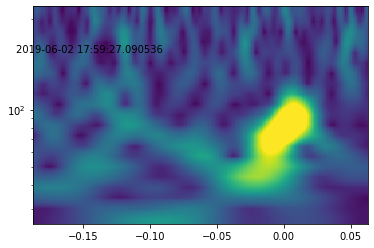

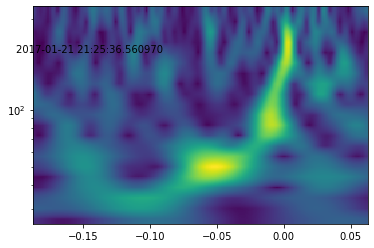

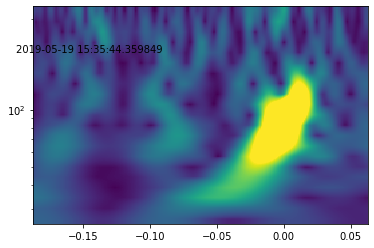

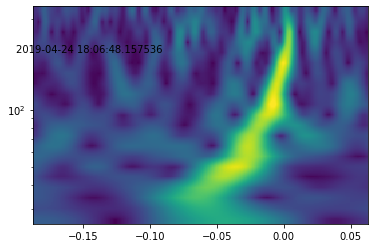

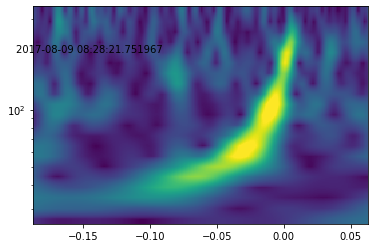

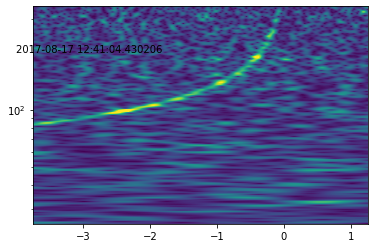

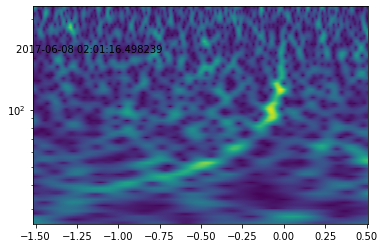

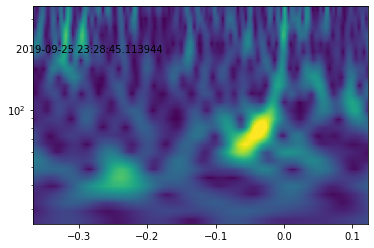

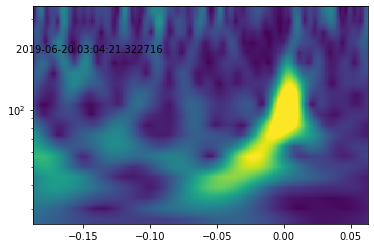

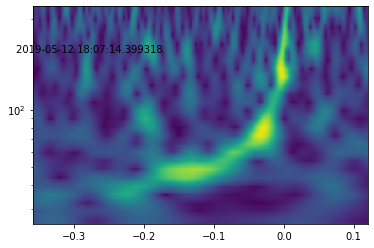

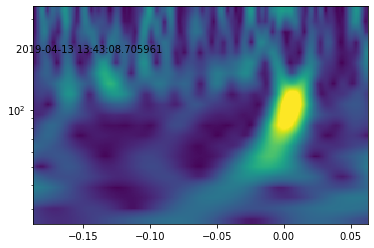

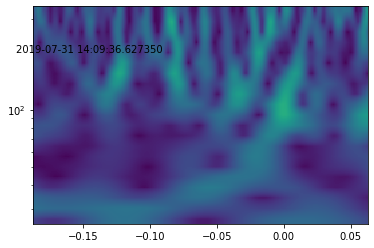

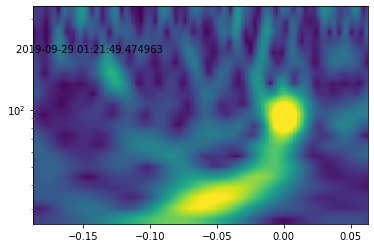

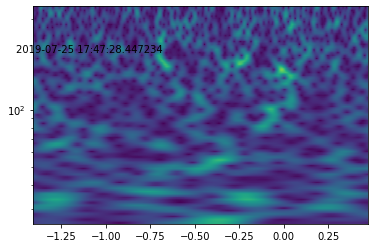

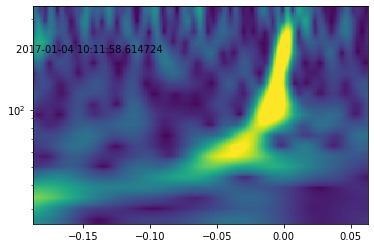

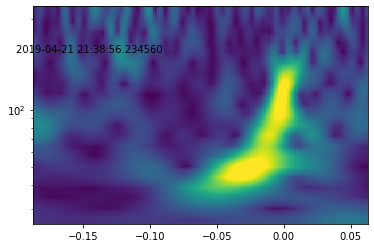

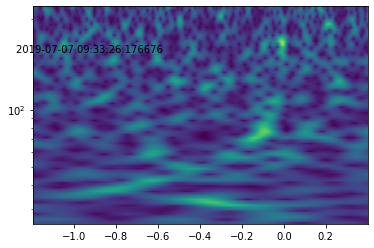

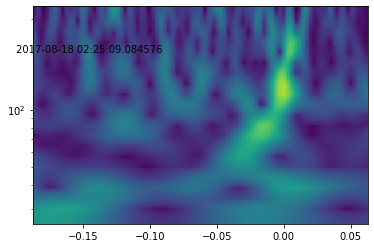

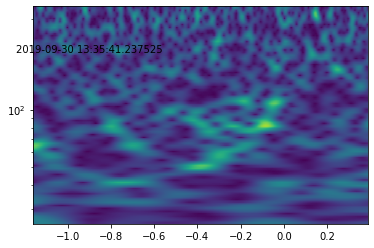

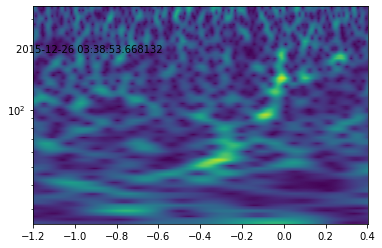

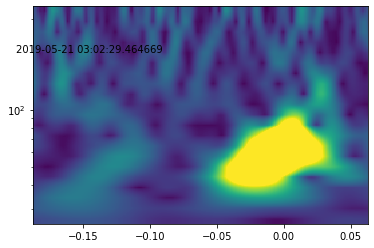

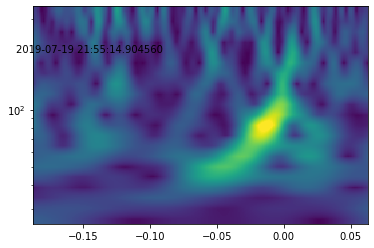

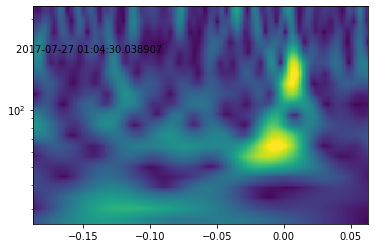

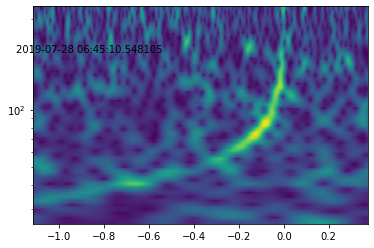

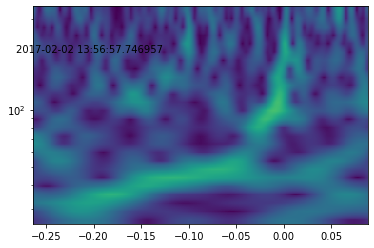

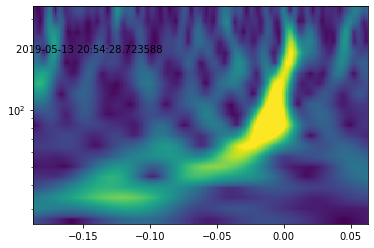

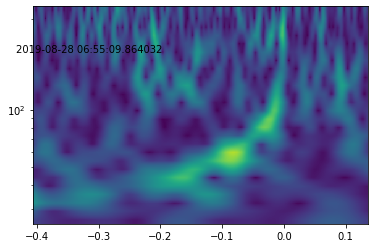

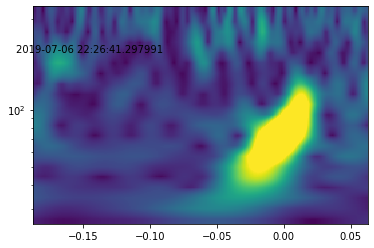

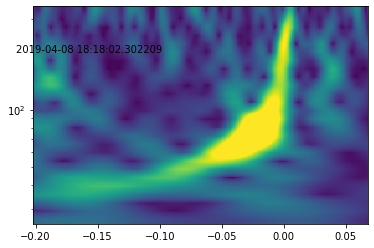

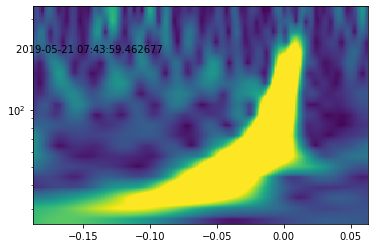

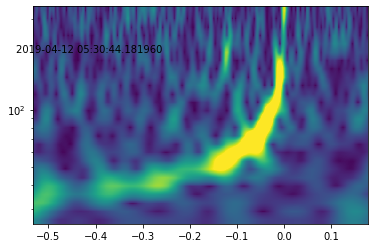

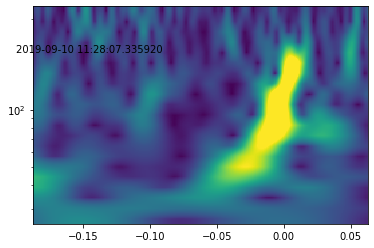

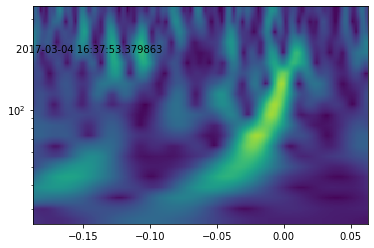

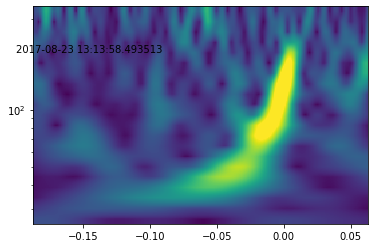

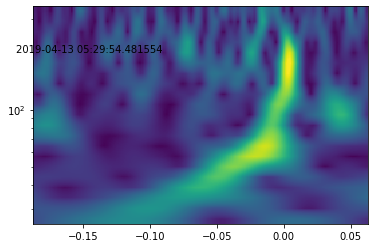

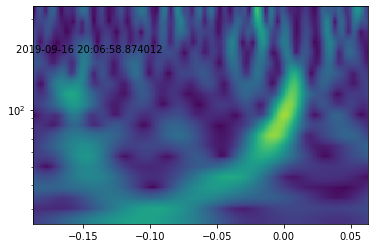

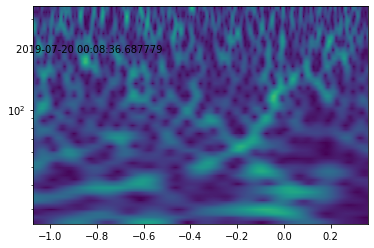

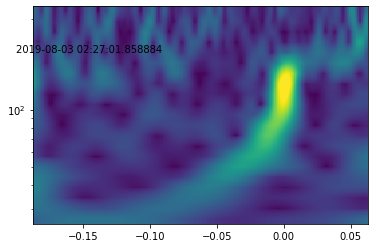

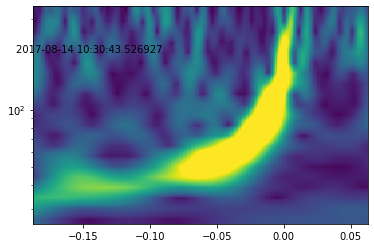

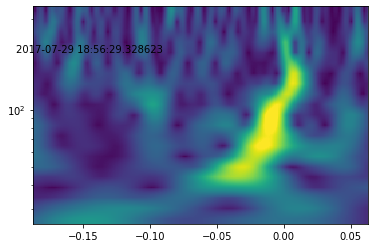

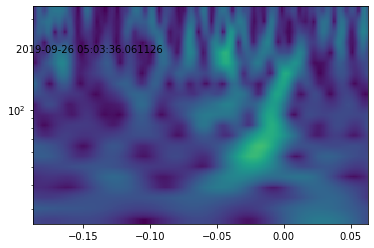

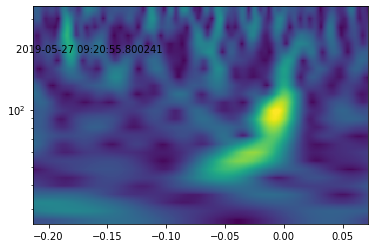

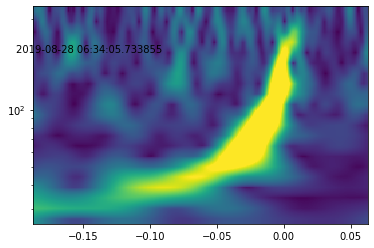

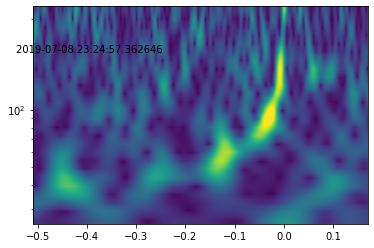

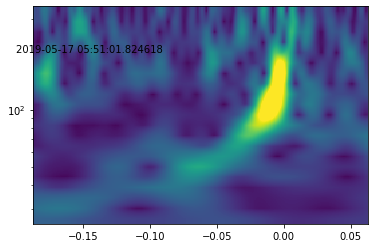

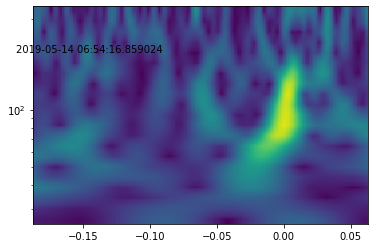

In [5]:
import glob, h5py
from pycbc.types import load_frequencyseries
from pycbc.detector import Detector
from pycbc.waveform.spa_tmplt import spa_length_in_time
import astropy.time
from pycbc.conversions import mtotal_from_mchirp_eta

ifos = ['H1', 'L1', 'V1']
dets = {}
for ifo in ifos:
    dets[ifo] = Detector(ifo)

fnames = glob.glob('../allposterior//*.hdf')
o.close()
o = h5py.File('qsave.hdf', 'w')

for fname in fnames:
    f = h5py.File(fname, 'r')
    ttime = f.attrs['trigger_time']
    logl = f['samples/loglikelihood'][:].argmax()
    ttime += f['samples/delta_tc'][logl]
    
    #if ttime != 1248112066.4472337:
    #    continue
    
    try:
        srcmchirp = f['samples/srcmchirp'][logl]
        mt = mtotal_from_mchirp_eta(srcmchirp, 0.25)
    except:
        mt = f['samples/srcmtotal'][logl]
    
    try:
        z = f['samples/redshift'][logl]
    except:
        z = 0
        
    mt = mt * (1 + z)
    dur = spa_length_in_time(mass1=mt / 2, mass2=mt / 2, phase_order=-1, f_lower=30.0)
    dur = dur if dur > 0.25 else 0.25
    dur = 5 if dur > 5 else dur
    
    try:
        ra = f['samples/ra'][logl]
        dec = f['samples/dec'][logl]
    except:
        ra = f.attrs['ra']
        dec = f.attrs['dec']
        
    pol = 0
    
    wstotal = None   
    vkeys = list(f['data'].keys())
    #vkeys = ['H1']
    
    for ifo in vkeys:
        fs = load_frequencyseries(fname, group='data/{}/stilde'.format(ifo))  

        dt = dets[ifo].time_delay_from_earth_center(ra, dec, ttime)
        fp, fc = dets[ifo].antenna_pattern(ra, dec, pol, ttime)
        dfac = fp - 1.0j * fc  # We are simplifying the inclination / polarization info here
        
        fs = fs / dfac
        ts = fs.to_timeseries().cyclic_time_shift(-dt)
        ts.start_time -= dt
        
        ws = (ts.to_frequencyseries() / ts.filter_psd(2, ts.delta_f, 20.0)).to_timeseries()
        
        if wstotal is None:
            wstotal = ws
        else:
            wstotal = wstotal.add_into(ws)
            
    wst = wstotal.whiten(2, 2)
    t = astropy.time.Time(ttime, format='gps', scale='utc')
    import pylab
    
    qval = 8
    if dur > 0.25:
        qval = 10
    if dur > 1.0:
        qval = 20
    if dur > 1.5:
        qval = 30
    if dur > 2.5:
        qval = 50
    if dur >= 5:
        qval = 95
    

    print(t.datetime, dur, ttime)
    
    wst = wst.time_slice(ttime - dur * 2 - 2, ttime + 2)
    times, freqs, power = wst.qtransform(.001, logfsteps=400,
                                        qrange=(qval, qval),
                                        frange=(25, 350))
    
    o.create_dataset('{}/times'.format(ttime), data=times)
    o.create_dataset('{}/freqs'.format(ttime), data=freqs)
    o.create_dataset('{}/power'.format(ttime), data=power)
    o[str(ttime)].attrs['dur'] = dur
    pylab.figure()
    pylab.text(-dur * 4/5.0, 200, t.datetime)
    pylab.pcolormesh(times - ttime, freqs, power**0.5, vmax=5)
    pylab.yscale('log')
    pylab.xlim(- dur * 0.75, dur * 0.25)
    
o.close()